In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sympy 
from tda.sim.sim_engine import Simulation
from tda.sim.sim_objects.lti_object import LTIObject
from tda.sim.sensors import clutter_model
from tda.sim.sensors.radar import Radar

from tda.tracker.filters.linear_kalman import LinearKalman

In [2]:
sim = Simulation()

R = np.eye(3)

platform = LTIObject(1, np.array([50, 50, 0]), sim, np.zeros((3, 3)))
radar = Radar(1, platform, 5.0, np.eye(3) * 2.25)
platform.add_payload(radar)

target_Q = np.zeros((6, 6))
target_Q[0, 0] = 0.25
target_Q[1, 1] = 0.33

target = LTIObject(2, np.array([10, 12, 0, 1, 2, 0]), sim, target_Q)

sim._sim_objects.extend([platform, target])

In [3]:
sim_records = sim.run()

In [14]:
sim_records

{'radar1': {'t': array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45., 50., 55., 60.]),
  'sensor_id': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
  'target_id': array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.]),
  'target_az': array([-2.38378362, -2.47087153, -2.57743109, -2.74069376, -3.13017983,
          2.53344541,  2.07333716,  1.67561292,  1.55089659,  1.46931421,
          1.40993065,  1.37509529,  1.29757669]),
  'target_el': array([1.57079633, 1.57079633, 1.57079633, 1.57079633, 1.57079633,
         1.57079633, 1.57079633, 1.57079633, 1.57079633, 1.57079633,
         1.57079633, 1.57079633, 1.57079633]),
  'target_rng': array([54.29943044, 42.10510089, 32.68682236, 23.3596735 , 16.31754831,
         16.25954668, 17.70933601, 25.50468379, 36.58880751, 45.95701014,
         55.31125336, 64.24110561, 75.14666816]),
  'sensor_x': array([50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50.]),
  'sensor_y': array([50., 50., 50., 50., 50., 50

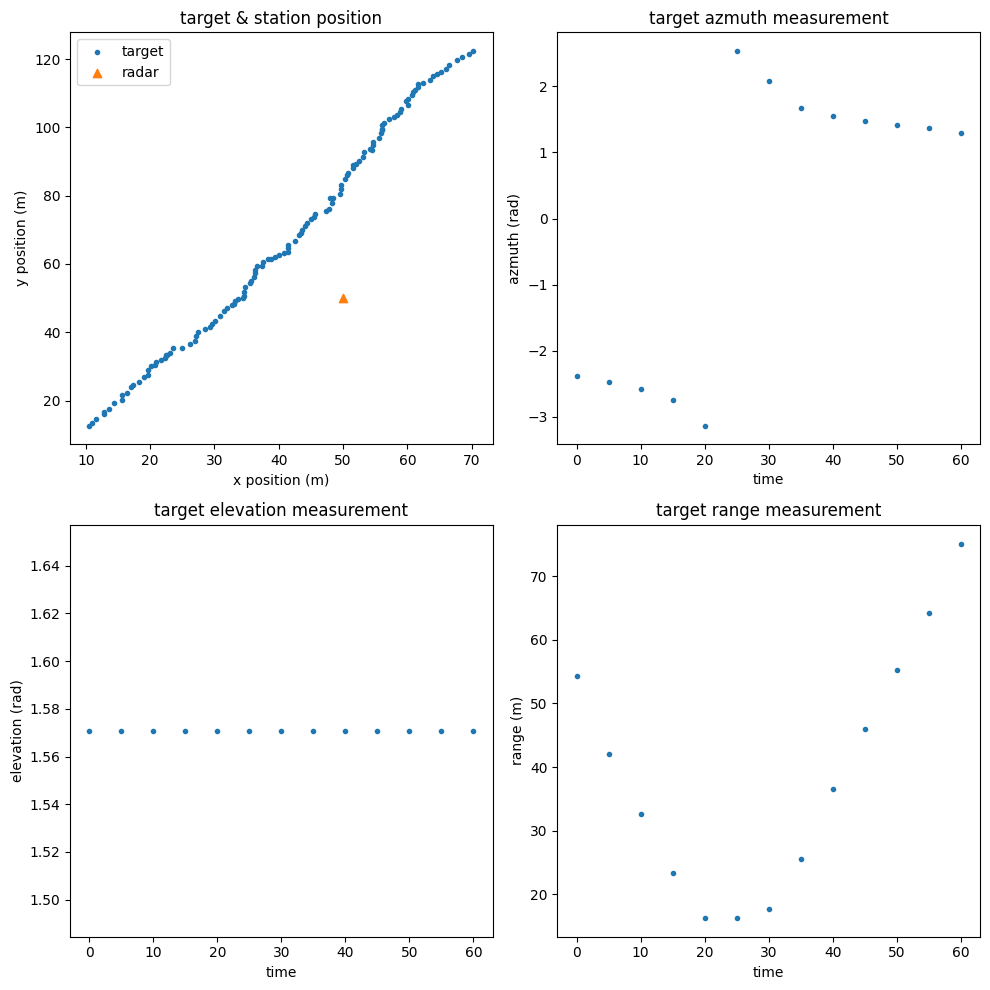

In [17]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches((10, 10))

axs[0, 0].scatter(sim_records["lti_object2"]["x"], sim_records["lti_object2"]["y"], marker=".", label="target")
axs[0, 0].scatter(sim_records["lti_object1"]["x"][0], sim_records["lti_object1"]["y"][0], marker="^", label="radar")
axs[0, 0].set_title("target & station position")
axs[0, 0].set_xlabel("x position (m)")
axs[0, 0].set_ylabel("y position (m)")
axs[0, 0].legend()

axs[0, 1].scatter(sim_records["radar1"]["t"], sim_records["radar1"]["target_az"], marker=".")
axs[0, 1].set_title("target azmuth measurement")
axs[0, 1].set_xlabel("time")
axs[0, 1].set_ylabel("azmuth (rad)")

axs[1, 0].scatter(sim_records["radar1"]["t"], sim_records["radar1"]["target_el"], marker=".")
axs[1, 0].set_title("target elevation measurement")
axs[1, 0].set_xlabel("time")
axs[1, 0].set_ylabel("elevation (rad)")

axs[1, 1].scatter(sim_records["radar1"]["t"], sim_records["radar1"]["target_rng"], marker=".")
axs[1, 1].set_title("target range measurement")
axs[1, 1].set_xlabel("time")
axs[1, 1].set_ylabel("range (m)")

fig.tight_layout()

In [19]:
def getH(X):
    x, y, z = X[0], X[1], X[2]
    
    return np.array([[                                                   -y/(x**2 + y**2),                                                     x/(x**2 + y**2),                                                                                            0],
                     [(x*z)/((1 - z**2/(x**2 + y**2 + z**2))**(1/2)*(x**2 + y**2 + z**2)**(3/2)), (y*z)/((1 - z**2/(x**2 + y**2 + z**2))**(1/2)*(x**2 + y**2 + z**2)**(3/2)), -(1/(x**2 + y**2 + z**2)**(1/2) - z**2/(x**2 + y**2 + z**2)**(3/2))/(1 - z**2/(x**2 + y**2 + z**2))**(1/2)],
                     [                                        x/(x**2 + y**2 + z**2)**(1/2),                                         y/(x**2 + y**2 + z**2)**(1/2),                                                                    z/(x**2 + y**2 + z**2)**(1/2)]
                    ])

In [ ]:
def F(dt: float):
    F = np.eye(6, dtype=np.float64)
    F[0, 3] = F[1, 4] = F[2, 5] = dt
    #F[3, 6] = F[4, 7] = F[5, 8] = dt
    #F[0, 6] = F[1, 7] = F[2, 8] = (dt ** 2) / 2

    return F

def Q(dt: float):
    Q = np.zeros((6, 6))
    Q[0, 0] = 0.35
    Q[1, 1] = 0.35

    return dt * Q

H = np.array([[1, 0, 0, 1, 0, 0],
              [0, 1, 0, 0, 1, 0],
              [0, 0, 1, 0, 0, 1]])

R = 3 * np.eye(3)
#R[0, 0] = R[1, 1] = R[2, 2] = 3

x_hat_0 = np.zeros(6)
P_hat_0 = 1e9 * np.eye(6)

kf = LinearKalman(x_hat_0, P_hat_0, F, H, Q, R)

for frame in sim.meas_queue:
    for m in frame:
        kf.update(m.localize_measurement())

kf_record = kf.record()

In [ ]:
fig, axs = plt.subplots(6)
fig.set_size_inches((10, 8))
axs[0].scatter(sim_records["lti_object2"]["t"], sim_records["lti_object2"]["x"], marker=".", label="true pos x")
axs[0].scatter(sim_records["oracle1"]["t"], sim_records["oracle1"]["target_x"], marker="x", label="measured pos x")
axs[0].plot(kf_record["t"], kf_record["x_hat"][:, 0], color="red", label="filtered pos x")
axs[0].legend()

axs[1].scatter(sim_records["lti_object2"]["t"], sim_records["lti_object2"]["y"], marker=".", label="true pos y")
axs[1].scatter(sim_records["oracle1"]["t"], sim_records["oracle1"]["target_y"], marker="x", label="measured pos y")
axs[1].plot(kf_record["t"], kf_record["x_hat"][:, 1], color="red", label="filtered pos y")

axs[2].scatter(sim_records["lti_object2"]["t"], sim_records["lti_object2"]["z"], marker=".", label="true pos z")
axs[2].scatter(sim_records["oracle1"]["t"], sim_records["oracle1"]["target_z"], marker="x", label="measured pos z")
axs[2].plot(kf_record["t"], kf_record["x_hat"][:, 2], color="red", label="filtered pos z")

axs[3].scatter(sim_records["lti_object2"]["t"], sim_records["lti_object2"]["xdot"], marker=".", label="true vel x")
axs[3].plot(kf_record["t"], kf_record["x_hat"][:, 3], color="red", label="filtered vel x")
axs[3].legend()

axs[4].scatter(sim_records["lti_object2"]["t"], sim_records["lti_object2"]["ydot"], marker=".", label="true vel y")
axs[4].plot(kf_record["t"], kf_record["x_hat"][:, 4], color="red", label="filtered pos y")

axs[5].scatter(sim_records["lti_object2"]["t"], sim_records["lti_object2"]["zdot"], marker=".", label="true vel z")
axs[5].plot(kf_record["t"], kf_record["x_hat"][:, 5], color="red", label="filtered pos z")

In [ ]:
sim2 = Simulation(sim_length=150)

extent = np.array([[-100, -100, 0],
                   [100, 100, 10]]).T

platform = LTIObject(1, np.array([50, 50, 0]), sim2, np.zeros((3, 3)))
oracle = Oracle(1, platform, 2.0, np.eye(3) * 2.25, prob_detect=1.0, field_of_regard=extent)
platform.add_payload(oracle)

target_Q = np.zeros((6, 6))
target_Q[0, 0] = 0.11
target_Q[1, 1] = 0.07

target = LTIObject(2, np.array([10, 12, 0, 1, 2, 0]), sim2, target_Q)

sim2._sim_objects.extend([platform, target])

sim2_records = sim2.run()

plt.title("simple ground target (reduced prob detect)")
plt.scatter(sim2_records["lti_object2"]["x"], sim2_records["lti_object2"]["y"])
plt.scatter(sim2_records["oracle1"]["target_x"] + sim2_records["oracle1"]["sensor_x"], sim2_records["oracle1"]["target_y"] + sim2_records["oracle1"]["sensor_y"], marker="x")
plt.scatter(sim2_records["oracle1"]["sensor_x"], sim2_records["oracle1"]["sensor_y"], marker="x")

In [ ]:
kf2 = LinearKalman(x_hat_0, P_hat_0, F, H, Q, R)

for frame in sim2.meas_queue:
    for m in frame:
        kf2.update(m.localize_measurement())

kf2_record = kf2.record()

fig, axs = plt.subplots(6)
fig.set_size_inches((10, 8))
axs[0].scatter(sim2_records["lti_object2"]["t"], sim2_records["lti_object2"]["x"], marker=".", label="true pos x")
axs[0].scatter(sim2_records["oracle1"]["t"], sim2_records["oracle1"]["target_x"], marker="x", label="measured pos x")
axs[0].plot(kf2_record["t"], kf2_record["x_hat"][:, 0], color="red", label="filtered pos x")
axs[0].legend()

axs[1].scatter(sim2_records["lti_object2"]["t"], sim2_records["lti_object2"]["y"], marker=".", label="true pos y")
axs[1].scatter(sim2_records["oracle1"]["t"], sim2_records["oracle1"]["target_y"], marker="x", label="measured pos y")
axs[1].plot(kf2_record["t"], kf2_record["x_hat"][:, 1], color="red", label="filtered pos y")

axs[2].scatter(sim2_records["lti_object2"]["t"], sim2_records["lti_object2"]["z"], marker=".", label="true pos z")
axs[2].scatter(sim2_records["oracle1"]["t"], sim2_records["oracle1"]["target_z"], marker="x", label="measured pos z")
axs[2].plot(kf2_record["t"], kf2_record["x_hat"][:, 2], color="red", label="filtered pos z")

axs[3].scatter(sim2_records["lti_object2"]["t"], sim2_records["lti_object2"]["xdot"], marker=".", label="true vel x")
axs[3].plot(kf2_record["t"], kf2_record["x_hat"][:, 3], color="red", label="filtered vel x")
axs[3].legend()

axs[4].scatter(sim2_records["lti_object2"]["t"], sim2_records["lti_object2"]["ydot"], marker=".", label="true vel y")
axs[4].plot(kf2_record["t"], kf2_record["x_hat"][:, 4], color="red", label="filtered pos y")

axs[5].scatter(sim2_records["lti_object2"]["t"], sim2_records["lti_object2"]["zdot"], marker=".", label="true vel z")
axs[5].plot(kf2_record["t"], kf2_record["x_hat"][:, 5], color="red", label="filtered pos z")